# Mean analysis for HBECs

In [6]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

import statsmodels.formula.api as smf
import statsmodels.api as sm
pd.set_option('display.max_rows', 600)

In [7]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [8]:
data_path = '/data_volume/memento/hbec/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [9]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [10]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Read 1D HT results

In [9]:
cts = ['C', 'B', 'BC', 'all_ct']
tps = [ '3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [16]:
def read_result():
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        adata_subset = sc.read(data_path + '/binary_test_stratified/{}_stratified.h5ad'.format(stim))
        ht_dict[stim] = memento.get_1d_ht_result(adata_subset)
        ht_dict[stim]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim]['de_pval'])
        ht_dict[stim]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim]['dv_pval'])
        moments_dict[stim] = memento.get_1d_moments(adata_subset, groupby='stim_indicator')
    return ht_dict,moments_dict

In [17]:
ht, moments = read_result()

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
  m = np.log(val[0])


In [19]:
tp = '6'
ct = 'all_ct'
for idx, stim in enumerate(stims):
    
    if idx == 0:
        df = ht[stim][['gene', 'de_coef', 'de_pval', 'de_fdr']].rename(columns=dict(zip(['de_coef', 'de_pval', 'de_fdr'], ['logfc_'+stim, 'pv_'+stim, 'fdr_'+stim])))
    else:
        a = ht[stim][['gene', 'de_coef', 'de_pval', 'de_fdr']].rename(columns=dict(zip(['de_coef', 'de_pval', 'de_fdr'], ['logfc_'+stim, 'pv_'+stim, 'fdr_'+stim])))
        df = df.merge(a, on='gene', how='outer')

### Graph ISG comparisons for each stim

In [21]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import statsmodels.formula.api as smf
import statsmodels.api as sm

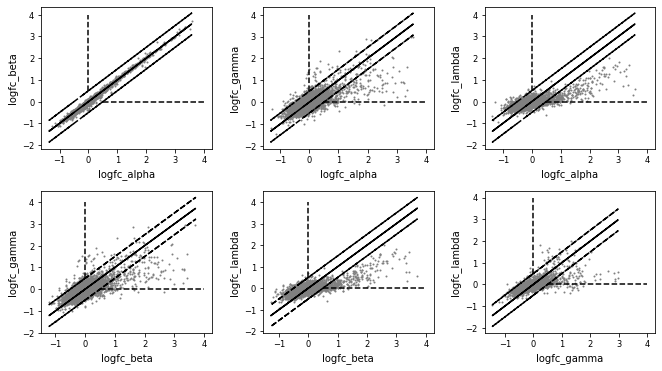

In [48]:
plt.figure(figsize=(11, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
cols = ['logfc_alpha','logfc_beta', 'logfc_gamma', 'logfc_lambda']
for idx, c in enumerate(itertools.combinations(cols,2)):
    
    subset = df[[c[0], c[1]]].copy()
    subset.dropna(inplace=True)
    subset = subset[(subset.max(axis=1) < 1000)&(subset.min(axis=1) > -1000)]

    x, y = subset[c[0]], subset[c[1]]

    plt.subplot(2, 3, idx+1)
    plt.scatter(x, y, s=1, color='grey');
    plt.xlabel(c[0]); plt.ylabel(c[1])
    # plt.plot([-1.5, 3], [-1.5, 3])
    xs = np.arange(0, x.max())
    plt.plot(x,x+0.5, '--', color='k')
    xs = np.arange(0.5, x.max())
    plt.plot(x,x, color='k')
    xs = np.arange(0, x.max()+0.5)
    plt.plot(x,x-0.5, '--', color='k')
    plt.plot([0, 0], [0.5, 4], '--', color='k')
    plt.plot([0.5, 4], [0, 0], '--', color='k')
    
    
#     plt.plot([0, 0.5, 0.5], [0.5, 0.5, 0], '--', color='k')

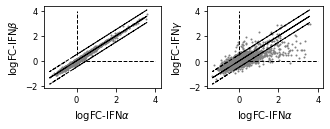

In [51]:
plt.figure(figsize=(5, 1.5))
plt.subplots_adjust(wspace=0.4)
cols = ['logfc_alpha','logfc_beta', 'logfc_gamma', 'logfc_lambda']
for idx, c in enumerate(itertools.combinations(cols,2)):
    
    subset = df[[c[0], c[1]]].copy()
    subset.dropna(inplace=True)
    subset = subset[(subset.max(axis=1) < 1000)&(subset.min(axis=1) > -1000)]

    x, y = subset[c[0]], subset[c[1]]

    plt.subplot(1, 2, idx+1);

    plt.scatter(x, y, s=1, color='grey');
    plt.xlabel(c[0]); plt.ylabel(c[1])
    # plt.plot([-1.5, 3], [-1.5, 3])
    xs = np.arange(0, x.max())
    plt.plot(x,x+0.5, '--', color='k', lw=1)
    xs = np.arange(0.5, x.max())
    plt.plot(x,x, color='k', lw=1)
    xs = np.arange(0, x.max()+0.5)
    plt.plot(x,x-0.5, '--', color='k', lw=1)
    plt.plot([0, 0], [0.5, 4], '--', color='k', lw=1)
    plt.plot([0.5, 4], [0, 0], '--', color='k', lw=1)
    plt.xlabel(r'logFC-IFN$\alpha$')

    if idx == 0:
        plt.ylabel(r'logFC-IFN$\beta$')
    if idx == 1:
        plt.ylabel(r'logFC-IFN$\gamma$')
        break
plt.savefig('stim_lfc_scatter.png', bbox_inches='tight', dpi=500)

### Create long/wide form of HT results

In [55]:
# Create longform data

longform = []
    
for stim in stims:

    a = ht[stim]
    a['stim'] = stim
    a['lfc'] = a['de_coef']
    a['fdr'] = a['de_fdr']
    longform.append(a[['gene', 'lfc', 'stim', 'fdr']].copy())

longform = pd.concat(longform)


In [58]:
wideform = longform.pivot(index='gene', columns=['stim'], values=['lfc', 'fdr'])#.loc[:, 'C'].loc[:, ['control', '']
wideform_fdr = longform.pivot(index='gene', columns=['stim'], values=['fdr'])#.loc[:, 'C'].loc[:, ['control', '']
wideform_hr = wideform

### Define type specific/shared ISGs

In [95]:
isg_types = ['type1', 'type2', 'type3','shared']
tps = [3, 6, 9, 24, 48]
tps=[6]
isg_class_df = pd.DataFrame()
wideform_hr = wideform
for isg_type in isg_types:
    if isg_type == 'type2': # gamma

        type1_both = wideform_hr['lfc'][['alpha', 'beta']].min(axis=1)
        rest = pd.concat([type1_both, wideform_hr['lfc']['lambda']], axis=1).max(axis=1)
        isg_class_df['is_type2'] = (wideform_hr['lfc']['gamma'] > 0.5) & (wideform_hr['lfc']['gamma'] > rest + 0.5) & (wideform_hr['fdr']['gamma'] < 0.05) 

    if isg_type == 'type1':

        type1_both = wideform_hr['lfc'][['alpha', 'beta']].max(axis=1)
        rest = pd.concat([wideform_hr['lfc']['gamma'], wideform_hr['lfc']['lambda']], axis=1).max(axis=1)
        isg_class_df['is_type1'] = (type1_both > 0.5) & (type1_both > rest + 0.5) & ((wideform_hr['fdr']['beta'] < 0.05) | (wideform_hr['fdr']['alpha'] < 0.05))
    
#     if isg_type == 'type3':

#         rest = pd.concat([wideform_hr['lfc']['alpha'], wideform_hr['lfc']['beta'], wideform_hr['lfc']['gamma']], axis=1).max(axis=1)
#         isg_class_df['is_type3'] = (wideform_hr['lfc']['lambda'] > 0.5) & (wideform_hr['lfc']['lambda'] > rest + 0.5) & (wideform_hr['fdr']['lambda'] < 0.05)

    if isg_type == 'shared':

        isg_class_df['is_shared'] = (wideform_hr['lfc'][['alpha', 'beta', 'gamma', 'lambda']].max(axis=1) > 0.5) & (wideform_hr['lfc'][['alpha', 'beta', 'gamma', 'lambda']].min(axis=1) > 0.)& (wideform_hr['fdr'][['alpha', 'beta', 'gamma', 'lambda']].max(axis=1) < 0.05)
        isg_class_df['is_shared'] = isg_class_df['is_shared'] & ~isg_class_df['is_type1'] & ~isg_class_df['is_type2'] #& ~isg_class_df['is_type3']
        
isg_class_df = isg_class_df[isg_class_df.sum(axis=1) > 0].copy()


### Consolidate an ISG class for each gene

In [48]:
def classify(row):
    
    if row['is_type1']: return 'type1'
    elif row['is_type2']: return 'type2'
    else: return 'shared'
    
    

In [ ]:
isg_class_df['overall_type'] = isg_class_df.apply(classify, axis=1)
isg_class_df.to_csv('../isg_classes.csv')

In [ ]:
isg_class_df.shape

In [99]:
isg_class_df.overall_type.value_counts()

shared    235
type1     218
type2      41
Name: overall_type, dtype: int64

### Read ISG classes

In [51]:
isg_classes = pd.read_csv('../isg_classes.csv')
t1_isg = isg_classes.query('overall_type =="type1"').gene.tolist()
t2_isg = isg_classes.query('overall_type =="type2"').gene.tolist()
shared_isg = isg_classes.query('overall_type == "shared"').gene.tolist()
all_isg = isg_classes[isg_classes.sum(axis=1) > 0].gene.tolist()

In [52]:
len(all_isg)

494

### DE gene heatmap

In [132]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N', 'club':'club'}
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])


In [133]:
# sc.pp.normalize_total(adata, target_sum=1e4)

In [134]:
# sc.pp.log1p(adata)

In [265]:
sc_heatmap = adata[adata.obs.time.isin(['6']) & adata.obs.ct.isin(['C']), all_isg].copy()
sc_heatmap = sc_heatmap[sc_heatmap.obs.sort_values('stim').index, :].copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [266]:
from matplotlib.colors import LinearSegmentedColormap


pal = sns.husl_palette(3, s=.45)
lut = dict(zip(['type1', 'type2', 'shared'], pal))
lut_ind = dict(zip(['type1', 'type2', 'shared'], [-1, 0, 1]))
colors = isg_classes['overall_type'].map(lut)
colors_ind = isg_classes['overall_type'].map(lut_ind)

myColors = sns.color_palette('husl')[:3]
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))



In [267]:
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [268]:
subsets = []
for stim in stims:
    a = pd.DataFrame(sc_heatmap[sc_heatmap.obs.stim == stim, :].X.toarray(), columns=sc_heatmap.var.index)
    a = a.rolling(10, closed='right').mean().dropna()
    subsets.append(a.copy())
heatmap = pd.concat(subsets).dropna()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [269]:
ordered_heatmaps = []
for gene_set in [t1_isg, t2_isg, shared_isg]:
    a = heatmap[gene_set]
    a /= a.max(axis=0).values.reshape(1, -1)
    cg = sns.clustermap(a, vmax=0.7, row_cluster=True, col_cluster=True, cmap='coolwarm', center=0, figsize=(4,2))
    row_order = cg.dendrogram_row.reordered_ind
    order = cg.dendrogram_col.reordered_ind
    plt.close()
    ordered_heatmaps.append(a.iloc[:, :].copy())
final_heatmap = pd.concat(ordered_heatmaps, axis=1, ignore_index=True)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


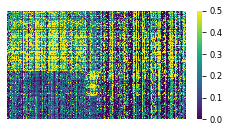

In [275]:
plt.figure(figsize=(4,2))
sns.heatmap(final_heatmap, vmax=0.5,cmap='viridis')
plt.xticks([]); plt.yticks([]);
plt.savefig('isg_type_heatmap.png', bbox_inches='tight', dpi=500)